### machine learning 5-fold comparison

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
# prepare (flatten) 5-fold dataset features and labels
feature_list_train_all = []
label_list_train_all = []

for i in range(5):

    trainpath = '../datasets/fivefold/'+str(i+1)+'fold_train_evidence.dataset'
    validpath = '../datasets/fivefold/'+str(i+1)+'fold_valid_evidence.dataset'
    train = pd.read_pickle(trainpath)
    test = pd.read_pickle(validpath)

    # fold-i label
    label_train = train['label'].values
    label_list_train_all.append(label_train)

    # fold-i features
    feature = np.zeros(shape=(train.shape[0],7225))
    for j in range(train.shape[0]):
        feature_list = []
        for item in train['fingerprint'][j]:
            feature_list.append(item) # 881
        for item in np.nditer(train['seqbefore'][j]):
            feature_list.append(item) # 1220
        for item in np.nditer(train['seqafter'][j]):
            feature_list.append(item) # 1220
        for item in train['variantfeature'][j]:
            feature_list.append(item) # 3904
        for k in range(len(feature_list)):
            feature[j, k] = feature_list[k]
    feature_list_train_all.append(feature)

feature_train_all = np.array(feature_list_train_all)
label_train_all = np.array(label_list_train_all)

print(feature_train_all.shape) # (5,480,7225)
print(label_train_all.shape) # (5,480)


(5, 464, 7225)
(5, 464)


In [3]:
# prepare (flatten) testset features and labels
alltestpath = '../datasets/middlefile/test_data_evidence.dataset'
alltest = pd.read_pickle(alltestpath)
label = alltest['label'].values
feature = np.zeros(shape=(alltest.shape[0],7225))
for j in range(alltest.shape[0]):
    feature_list = []
    for item in alltest['fingerprint'][j]:
        feature_list.append(item) # 881
    for item in np.nditer(alltest['seqbefore'][j]):
        feature_list.append(item) # 1220
    for item in np.nditer(alltest['seqafter'][j]):
        feature_list.append(item) # 1220
    for item in alltest['variantfeature'][j]:
        feature_list.append(item) # 3904
    for k in range(len(feature_list)):
        feature[j, k] = feature_list[k]
print(feature.shape) # (153, 7225)
print(label.shape) # (153,)

(130, 7225)
(130,)


In [4]:
label_train_all = label_train_all.astype('int')
label = label.astype('int')

In [5]:
print(feature_train_all[0])

[[1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 1. 0.]]


#### Model 1: Decision tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    max_depth = [1,3,5,10,15,20],
    max_leaf_nodes = [2,3,4,5,10,15,20],)

dtModel = DecisionTreeClassifier()
grid = GridSearchCV(
    dtModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[2],label_train_all[2])

In [38]:
print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.849158
best paramaters:
max_depth = 5
max_leaf_nodes = 20


(mean) ACC:  0.7892307692307693 Precision:  0.7992028433292543 Recall:  0.9172413793103449 F1:  0.8536326096939908 AUC:  0.7921301775147928
(std) ACC:  0.0198216903488079 Precision:  0.02564158140186889 Recall:  0.021069313540026825 F1:  0.011287542141019916 AUC:  0.02559151417644558


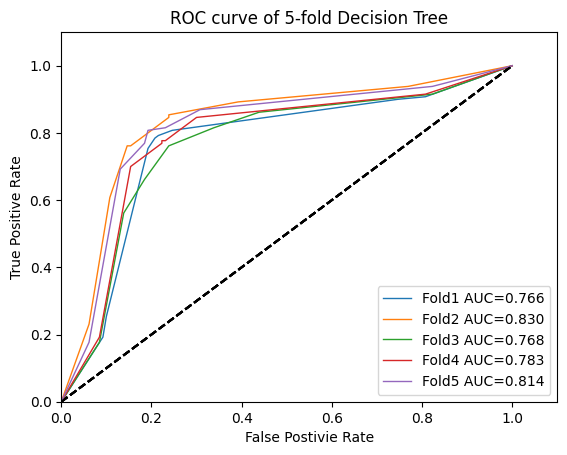

In [39]:
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

dt_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_dt = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=20)
    clf_dt.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_dt.predict(feature)                                   
    y_score_pro = clf_dt.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    dt_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Decision Tree')
plt.savefig('images/roc-5fold-decision-tree.png',dpi=300)
plt.show()

#### Model 2: Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    n_estimators = [10,20,30,40],
    max_depth = [5,10,20],
    min_samples_split = [10,20,40,60],)

rfModel = RandomForestClassifier()
grid = GridSearchCV(
    rfModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[4],label_train_all[4])

In [24]:
print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.827583
best paramaters:
max_depth = 20
min_samples_split = 10
n_estimators = 30


(mean) ACC:  0.7861538461538461 Precision:  0.7926910084788633 Recall:  0.9218390804597701 F1:  0.8522506573832389 AUC:  0.8513668639053253
(std) ACC:  0.007536891516255906 Precision:  0.008997729166728658 Recall:  0.01689303270884948 F1:  0.005698343843822313 AUC:  0.012925038323529925


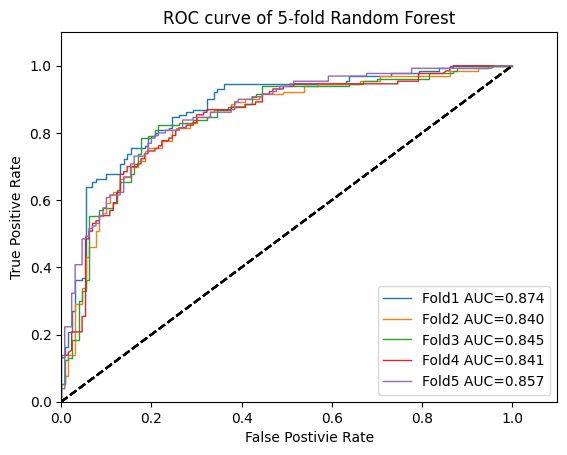

In [25]:
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

rf_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_rf = RandomForestClassifier(n_estimators=30, max_depth=20, min_samples_split=10)
    clf_rf.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_rf.predict(feature)                                   
    y_score_pro = clf_rf.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    rf_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Random Forest')
plt.savefig('images/roc-5fold-random-forest.png',dpi=300)
plt.show()

#### Model 3: SVM

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    gamma = [1e-4, 1e-3, 0.01, 0.1, 1, 10],
    C = [100, 10, 1, 0.1, 1e-2, 1e-3],)

svmModel = SVC()
grid = GridSearchCV(
    svmModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[0],label_train_all[0])

print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.769355
best paramaters:
C = 10
gamma = 0.0001


(mean) ACC:  0.7015384615384616 Precision:  0.69491339367703 Recall:  0.9885057471264368 F1:  0.8160380765483076 AUC:  0.7409822485207102
(std) ACC:  0.01780897985044649 Precision:  0.013078349285128726 Recall:  0.0 F1:  0.008995738110033825 AUC:  0.018606079596794608


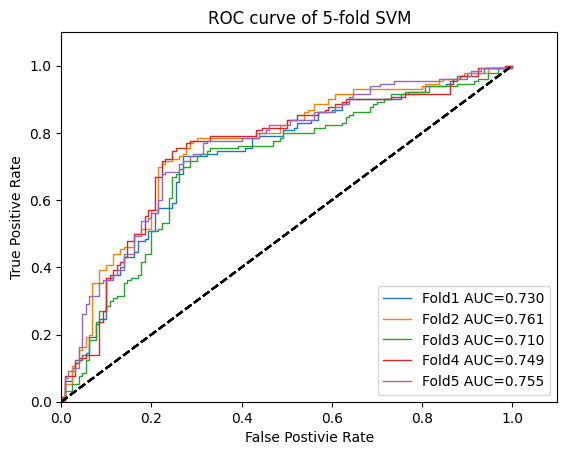

In [17]:
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

svm_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_svm = SVC(probability = True)
    clf_svm.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_svm.predict(feature)                                   
    y_score_pro = clf_svm.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    svm_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold SVM')
plt.savefig('images/roc-5fold-svm.png',dpi=300)
plt.show()

#### Model 4: KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    n_neighbors = [20,30,40,50,60,70,80,100],)

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True,scoring='roc_auc')
grid = grid.fit(feature_train_all[4],label_train_all[4])

print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.673610
best paramaters:
n_neighbors = 100


(mean) ACC:  0.6676923076923076 Precision:  0.6713502563633035 Recall:  0.9862068965517242 F1:  0.7988681204569055 AUC:  0.7010059171597633
(std) ACC:  0.005756395979652233 Precision:  0.0019206122898114608 Recall:  0.008601511233963074 F1:  0.004179617912349342 AUC:  0.01568006028260159


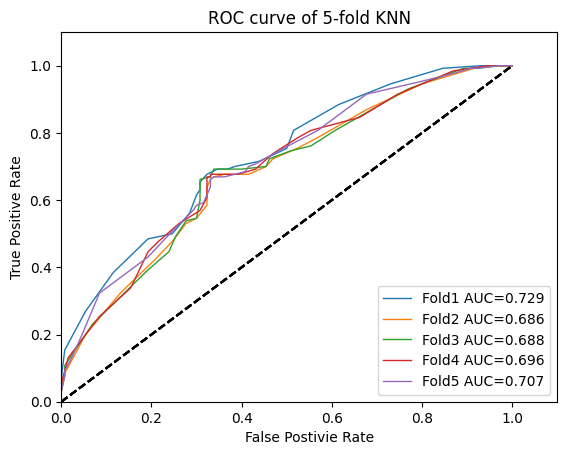

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

knn_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_knn = KNeighborsClassifier(n_neighbors = 30)
    clf_knn.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_knn.predict(feature)                                   
    y_score_pro = clf_knn.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    knn_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold KNN')
plt.savefig('images/roc-5fold-knn.png',dpi=300)
plt.show()

#### Model 5: Naive Bayes

(mean) ACC:  0.5953846153846154 Precision:  0.9169026301843639 Recall:  0.4344827586206897 F1:  0.5877543631029291 AUC:  0.6001005917159763
(std) ACC:  0.035948681370916676 Precision:  0.012614799783302098 Recall:  0.05555423436135436 F1:  0.050251774914194164 AUC:  0.03731464631659871


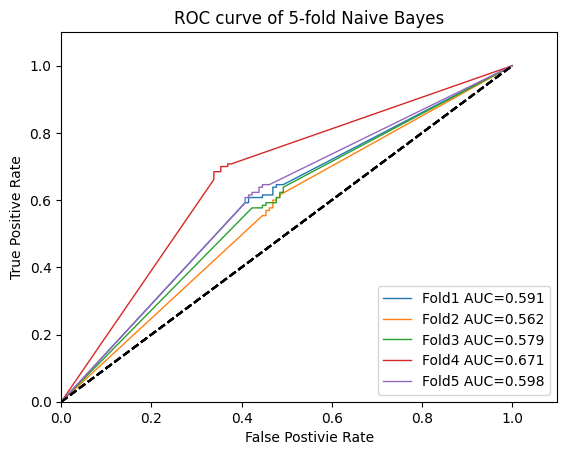

In [71]:
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

nb_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_nb = GaussianNB()
    clf_nb.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_nb.predict(feature)                                   
    y_score_pro = clf_nb.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    nb_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Naive Bayes')
plt.savefig('images/roc-5fold-nb.png',dpi=300)
plt.show()

#### Model 6: Logistic Regression

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [58]:

tuned_parameters = {'penalty':['l1','l2'],
                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
                   
lrmodel = LogisticRegression()

import warnings
warnings.filterwarnings('ignore')

grid = GridSearchCV(
    lrmodel,tuned_parameters,cv = 5,return_train_score = True,scoring='roc_auc')
grid = grid.fit(feature_train_all[0],label_train_all[0])

print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.799931
best paramaters:
C = 0.01
penalty = l2


(mean) ACC:  0.7553846153846153 Precision:  0.7818354691852164 Recall:  0.8804597701149424 F1:  0.8280740470271685 AUC:  0.8295029585798817
(std) ACC:  0.005756395979652196 Precision:  0.00858740705786749 Recall:  0.015591563179598351 F1:  0.004728626100734236 AUC:  0.01535346641836421


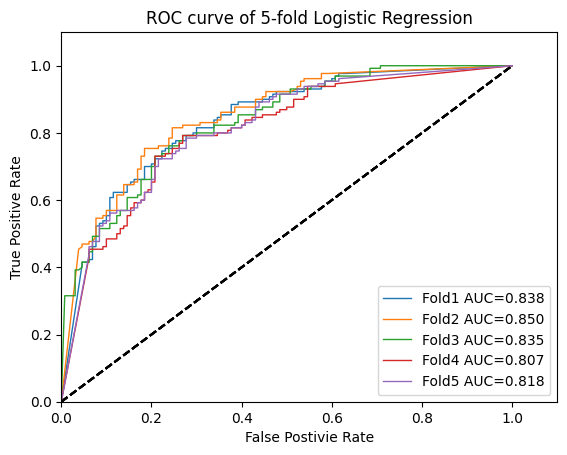

In [59]:
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

lr_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_lr = LogisticRegression(C=0.01, penalty='l2')
    clf_lr.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_lr.predict(feature)                                   
    y_score_pro = clf_lr.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    lr_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Logistic Regression')
plt.savefig('images/roc-5fold-lr.png',dpi=300)
plt.show()

#### Emden

[0.8307692307692308, 0.823076923076923, 0.8461538461538461, 0.8384615384615385, 0.8384615384615385]
[0.8494623655913979, 0.8404255319148937, 0.8681318681318682, 0.8837209302325582, 0.8367346938775511]
[0.9080459770114943, 0.9080459770114943, 0.9080459770114943, 0.8735632183908046, 0.9425287356321839]
[0.8777777777777779, 0.87292817679558, 0.8876404494382023, 0.8786127167630059, 0.8864864864864864]
[0.9041420118343195, 0.9157988165680474, 0.9127218934911242, 0.9118934911242603, 0.9075739644970414]
(mean) ACC:  0.8353846153846154 Precision:  0.8556950779496537 Recall:  0.9080459770114941 F1:  0.8806891214522106 AUC:  0.9104260355029586
(std) ACC:  0.007844645405527368 Precision:  0.017729207821161448 Recall:  0.021808811449437072 F1:  0.005566867027274306 AUC:  0.004096692050093591


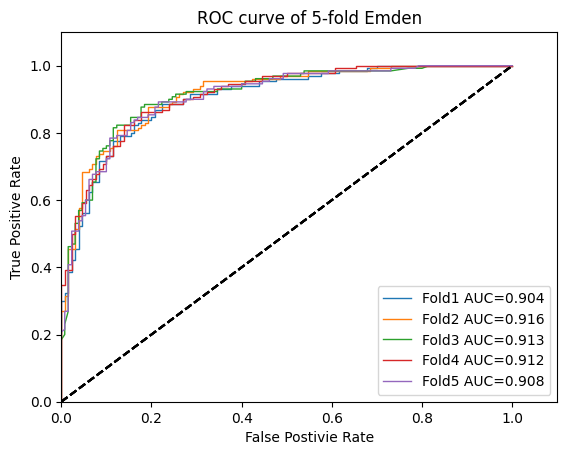

In [45]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

def softmax(vec):
    """Compute the softmax in a numerically stable way."""
    vec = vec - np.max(vec)  # softmax(x) = softmax(x+c)
    exp_x = np.exp(vec)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

emden_prob_list = []

for i in range(5):
    label = np.load('../model/pred_results_5fold/' + str(i+1) + 'fold_label.npy')
    pred = np.load('../model/pred_results_5fold/' + str(i+1) + 'fold_pred.npy')
    prob = np.load('../model/pred_results_5fold/' + str(i+1) + 'fold_pred_prob.npy')
    raw = np.load('../model/pred_results_5fold/' + str(i+1) + 'fold_pred_raw.npy')

    '''
    print(label)
    print(pred)
    #print(prob)
    print(raw)
    '''

    y_one_hot = to_categorical(label)
    y_score_pro_list = []
    for j in range(prob.shape[0]):
        y_score_pro_list.append([1-prob[j],prob[j]])
    y_score_pro = np.array(y_score_pro_list)

    emden_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, pred))
    precision_list.append(precision_score(label, pred))
    recall_list.append(recall_score(label, pred))
    f1_list.append(f1_score(label, pred))
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)
print(auc_list)

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Emden')
plt.savefig('images/roc-5fold-emden.png',dpi=300)
plt.show()

#### compare all

(130, 2)


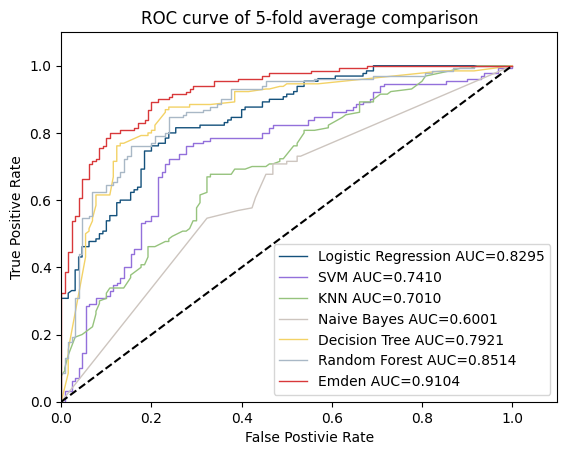

In [73]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

print(dt_prob_list[0].shape) # (153, 2)

def mean_prob(prob_list):
    sum_array = np.zeros((130,2))
    mean_array = np.zeros((130,2))
    for arr in prob_list:
        for i in range(130):
            sum_array[i][0] += arr[i][0]
            sum_array[i][1] += arr[i][1]
    for i in range(130):
        mean_array[i][0] = sum_array[i][0]/5
        mean_array[i][1] = sum_array[i][1]/5
    return mean_array

lr_prob = mean_prob(lr_prob_list)
nb_prob = mean_prob(nb_prob_list)
dt_prob = mean_prob(dt_prob_list)
rf_prob = mean_prob(rf_prob_list)
svm_prob = mean_prob(svm_prob_list)
knn_prob = mean_prob(knn_prob_list)
emden_prob = mean_prob(emden_prob_list)

y_one_hot = to_categorical(label)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_one_hot.ravel(),lr_prob.ravel())
fpr_nb, tpr_nb, thresholds_rf = roc_curve(y_one_hot.ravel(),nb_prob.ravel())
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_one_hot.ravel(),dt_prob.ravel())
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_one_hot.ravel(),rf_prob.ravel())
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_one_hot.ravel(),svm_prob.ravel())
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_one_hot.ravel(),knn_prob.ravel())
fpr_emden, tpr_emden, thresholds_emden = roc_curve(y_one_hot.ravel(),emden_prob.ravel())

plt.plot(fpr_lr, tpr_lr, linewidth = 1,label='Logistic Regression AUC=0.8295', color='#14517C')
plt.plot(fpr_svm, tpr_svm, linewidth = 1,label='SVM AUC=0.7410', color='#9370DB')
plt.plot(fpr_knn, tpr_knn, linewidth = 1,label='KNN AUC=0.7010', color='#96C37D')
plt.plot(fpr_nb, tpr_nb, linewidth = 1,label='Naive Bayes AUC=0.6001', color='#CDC5BF')
plt.plot(fpr_dt, tpr_dt, linewidth = 1,label='Decision Tree AUC=0.7921', color='#F3D266')
plt.plot(fpr_rf, tpr_rf, linewidth = 1,label='Random Forest AUC=0.8514', color='#A9B8C6')
plt.plot(fpr_emden, tpr_emden, linewidth = 1,label='Emden AUC=0.9104', color='#D8383A')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold average comparison')
plt.savefig('images/5fold-comparison.png',dpi=300)
plt.show()